# Dense Array HVSR Processing with Parallelization

This notebook demonstrates how to use `hvsr-lite` for processing dense nodal arrays with parallelization.


In [1]:

import os
import glob
import pandas as pd
import pathlib
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# hvsr-lite imports
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from obspy import read, Stream
import time
from multiprocessing import cpu_count

from hvsr_lite.core import (
    compute_hvsr, 
    compute_hvsr_batch, 
    compute_hvsr_array,
    HVSRResult
)
from hvsr_lite.utils import stream_to_dict

print("Imports successful")

Imports successful


In [2]:
DATA_FOLDER = "/Users/shihao/Research/CSM/Projects/BHP/BHP_OCELOT/SEISMIC/Data" 
OUTPUT_DIR = "./output" 
EXCEL_FILE = "2022_OCELOT_deployement_summary.xlsx" 

os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Data folder: {DATA_FOLDER}")
print(f"Output directory: {OUTPUT_DIR}")

if os.path.exists(DATA_FOLDER):
    print("Data folder found")
else:
    print("Data folder not found - using synthetic data for demonstration")
    DATA_FOLDER = None


Data folder: /Users/shihao/Research/CSM/Projects/BHP/BHP_OCELOT/SEISMIC/Data
Output directory: ./output
Data folder found


In [3]:
def load_and_group_seismic_files(data_folder):
    """
    File naming pattern: {station_id}..{network}.{location}.{year}.{month}.{day}.{hour}.{minute}.{second}.{millisecond}.{component}_RESPREMOVED.miniseed
    Example: 453000893..0.22.2022.08.05.00.00.00.000.E_RESPREMOVED.miniseed
    """
    if not data_folder or not os.path.exists(data_folder):
        print("No real data folder found, returning empty list")
        return []
    
    # Find all .mseed files
    all_files = glob.glob(os.path.join(data_folder, "*_RESPREMOVED.miniseed"))
    all_files.extend(glob.glob(os.path.join(data_folder, "*_RESPREMOVED.mseed")))
    print(f"Found {len(all_files)} MiniSEED files")
    
    frames_dict = defaultdict(list)
    for f in all_files:
        base = os.path.basename(f)
        
        parts = base.split('.')
        if len(parts) < 11: 
            print(f"Skipping file with unexpected naming pattern: {base}")
            continue
            
        key = '.'.join(parts[0:9])  # e.g., 453000893..0.22.2022.08.05.00.00.00.000
        frames_dict[key].append(f)
    
    frames = [sorted(file_list) for file_list in frames_dict.values() if len(file_list) == 3]
    
    print(f"Found {len(frames)} complete 3-component recordings")
    
    for fname_set in frames:
        for file in fname_set:
            if not pathlib.Path(file).exists():
                raise FileNotFoundError(f"file {file} not found; check spelling.")
    
    return frames

if DATA_FOLDER:
    seismic_frames = load_and_group_seismic_files(DATA_FOLDER)
    print(f"Loaded {len(seismic_frames)} seismic recordings")


Found 6 MiniSEED files
Found 2 complete 3-component recordings
Loaded 2 seismic recordings


In [5]:
def load_station_metadata(excel_file):
    """
    Load station metadata from Excel file.
    """
    if not os.path.exists(excel_file):
        print(f"Excel file {excel_file} not found - using default metadata")
        return None
    
    try:
        df = pd.read_excel(excel_file)
        print(f"Loaded metadata for {len(df)} stations")
        return df
    except Exception as e:
        print(f"Error loading Excel file: {e}")
        return None

def get_station_coordinates(df, filename):
    """
    Get station coordinates from metadata DataFrame.
    """
    if df is None:
        return None, None, None
    
    try:
        df['File'] = df['File'].astype(str).str.strip()
        filename = str(filename).strip()
        row = df[df['File'] == filename]
        
        if not row.empty:
            latitude = row.iloc[0]['Latitude']
            longitude = row.iloc[0]['Longitude']
            elevation = row.iloc[0].get('Elevation', None)
            return latitude, longitude, elevation
        else:
            return None, None, None
    except Exception as e:
        print(f"Error getting coordinates for {filename}: {e}")
        return None, None, None

# Load station metadata
station_metadata = load_station_metadata(EXCEL_FILE)


Loaded metadata for 207 stations


In [6]:
def process_single_station_hvsr_lite(file_paths, station_id, output_dir=None):
    """
    Process a single station using hvsr-lite.
    """
    try:
        st_all = Stream()
        for file_path in file_paths:
            st_all += read(file_path)
        
        st_preprocessed = st_all.copy()
        st_preprocessed.detrend(type='linear')
        st_preprocessed.filter('bandpass', freqmin=0.1, freqmax=24.0, corners=4, zerophase=True)
        
        hvsr_data = stream_to_dict(st_preprocessed)
        horizontal_data = np.column_stack([hvsr_data['north'], hvsr_data['east']])
        vertical_data = hvsr_data['vertical']
        sampling_rate = hvsr_data['sampling_rate']
        
        result = compute_hvsr(
            horizontal_data=horizontal_data,
            vertical_data=vertical_data,
            sampling_rate=sampling_rate,
            window_length=200.0, 
            overlap=0.5, 
            smoothing_method='custom_ko',  # Konno_and_Ohmachi Method
            ko_bandwidth=40.0, 
            horizontal_combine='geometric_mean', 
            min_frequency=0.1,
            max_frequency=21.0,  
            anti_aliasing_filter=True
        )
        
        return result
        
    except Exception as e:
        print(f"Error processing station {station_id}: {e}")
        return None

if seismic_frames:
    print("Processing with hvsr-lite...")
    test_station_files = seismic_frames[1]  # Use first station for testing
    
    station_id = os.path.basename(test_station_files[0]).split('..')[0]
    
    result = process_single_station_hvsr_lite(test_station_files, station_id)
    if result:
        print(f"Successfully processed station {station_id}")
        print(f"  Frequency range: {result.frequencies[0]:.3f} - {result.frequencies[-1]:.2f} Hz")
        print(f"  Peak HVSR: {result.hvsr_values.max():.2f} at {result.frequencies[result.hvsr_values.argmax()]:.2f} Hz")
    else:
        print(f"Failed to process station {station_id}")
else:
    print("No real data available for testing")


Processing with hvsr-lite...


Processing windows: 100%|██████████| 863/863 [00:08<00:00, 102.31win/s]


Successfully processed station 453000225
  Frequency range: 0.105 - 20.48 Hz
  Peak HVSR: 6.61 at 1.71 Hz


In [7]:
def batch_process_stations_hvsr_lite(seismic_frames, station_metadata, output_dir, n_workers=None):
    """
    Batch process multiple stations using hvsr-lite parallel processing.
    """
    if not seismic_frames:
        print("No seismic data to process")
        return {}
    
    # Prepare station data for batch processing
    stations_data = []
    
    for i, file_paths in enumerate(seismic_frames):
        
        station_id = os.path.basename(file_paths[0]).split('..')[0]
        
        try:
            
            st_all = Stream()
            for file_path in file_paths:
                st_all += read(file_path)
            
            st_preprocessed = st_all.copy()
            st_preprocessed.detrend(type='linear')
            st_preprocessed.filter('bandpass', freqmin=0.1, freqmax=24.0, corners=4, zerophase=True)
            
            hvsr_data = stream_to_dict(st_preprocessed)
            horizontal_data = np.column_stack([hvsr_data['north'], hvsr_data['east']])
            vertical_data = hvsr_data['vertical']
            sampling_rate = hvsr_data['sampling_rate']
            
            station_data = {
                'station_id': station_id,
                'horizontal_data': horizontal_data,
                'vertical_data': vertical_data,
                'sampling_rate': sampling_rate
            }
            stations_data.append(station_data)
            
        except Exception as e:
            print(f"Error preparing station {station_id}: {e}")
            continue
    
    print(f"Prepared {len(stations_data)} stations for batch processing")
    
    # Process in parallel using hvsr-lite batch processing
    results = compute_hvsr_batch(
        stations_data,
        n_workers=n_workers or cpu_count(),
        use_threading=True,  # Use threading for better memory efficiency
        window_length=200.0,
        smoothing_method='custom_ko',
        ko_bandwidth=40.0,
        horizontal_combine='geometric_mean',
        min_frequency=0.1,
        max_frequency=21.0,
        anti_aliasing_filter=True
    )
    
    # Convert to dictionary format
    results_dict = dict(results)
    
    print(f"Successfully processed {len(results_dict)} stations")
    
    return results_dict

# Process all stations if real data is available
if seismic_frames:
    print("\n-- Batch Processing All Stations --")
    all_results = batch_process_stations_hvsr_lite(
        seismic_frames, 
        station_metadata, 
        OUTPUT_DIR, 
        n_workers=2  # Adjust based on your system
    )
    
    # Print summary
    if all_results:
        print(f"\n-- Processing Summary --")
        print(f"Total stations processed: {len(all_results)}")
        
        # Calculate statistics
        peak_frequencies = []
        peak_amplitudes = []
        
        for station_id, result in all_results.items():
            peak_idx = result.hvsr_values.argmax()
            peak_freq = result.frequencies[peak_idx]
            peak_amp = result.hvsr_values[peak_idx]
            peak_frequencies.append(peak_freq)
            peak_amplitudes.append(peak_amp)
        
        print(f"Peak frequency range: {min(peak_frequencies):.2f} - {max(peak_frequencies):.2f} Hz")
        print(f"Peak amplitude range: {min(peak_amplitudes):.2f} - {max(peak_amplitudes):.2f}")
        print(f"Mean peak frequency: {np.mean(peak_frequencies):.2f} Hz")
else:
    print("No real data available for batch processing")
    all_results = {}



-- Batch Processing All Stations --
Prepared 2 stations for batch processing


Processing windows: 100%|██████████| 1268/1268 [00:19<00:00, 65.33win/s]


Completed 2/2 stations
Successfully processed 2 stations

-- Processing Summary --
Total stations processed: 2
Peak frequency range: 1.72 - 6.77 Hz
Peak amplitude range: 1.78 - 6.62
Mean peak frequency: 4.24 Hz



=== Creating Visualization Plots ===
Saved plot for station 453000893: ./output/453000893.png
Saved plot for station 453000225: ./output/453000225.png
Created plots for 2 stations in ./output


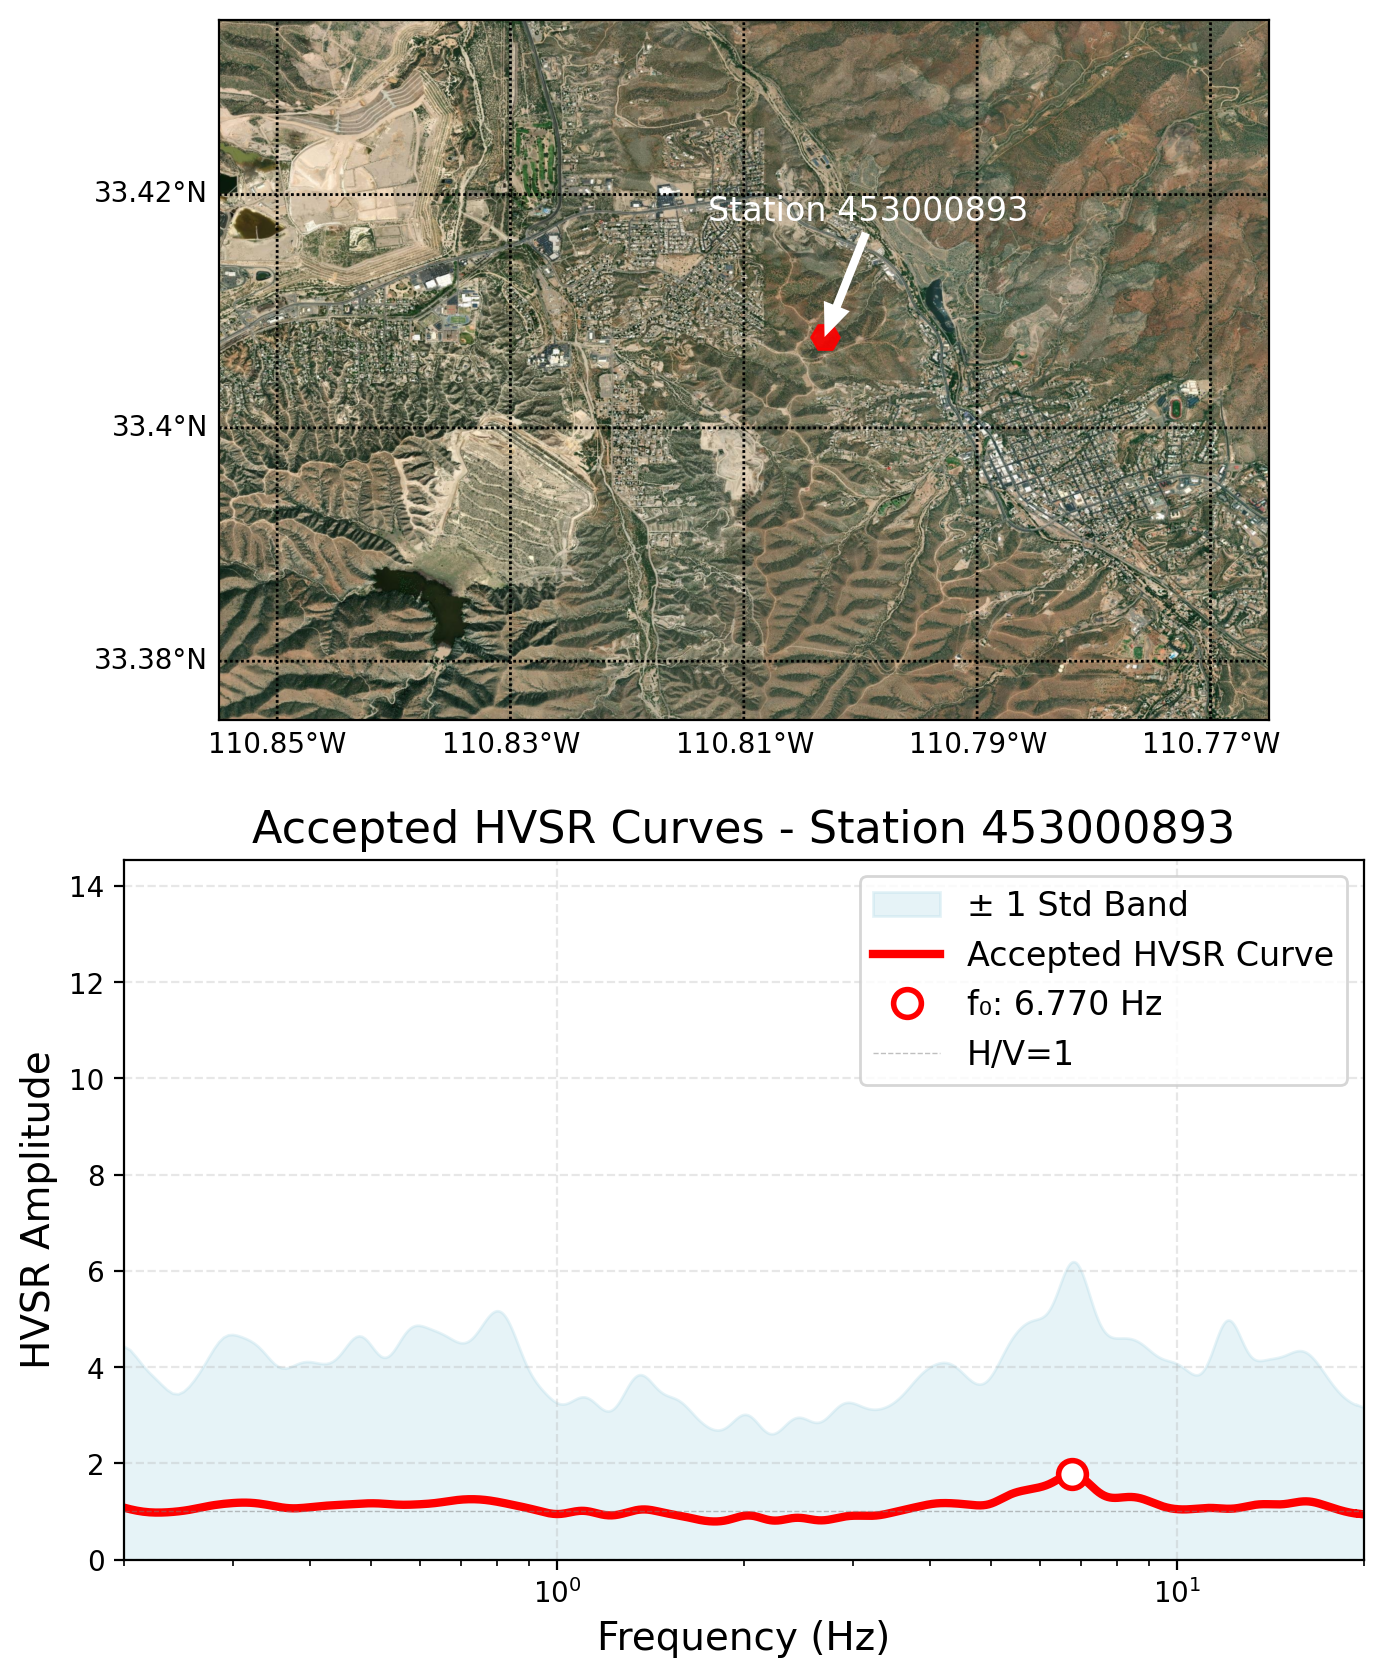

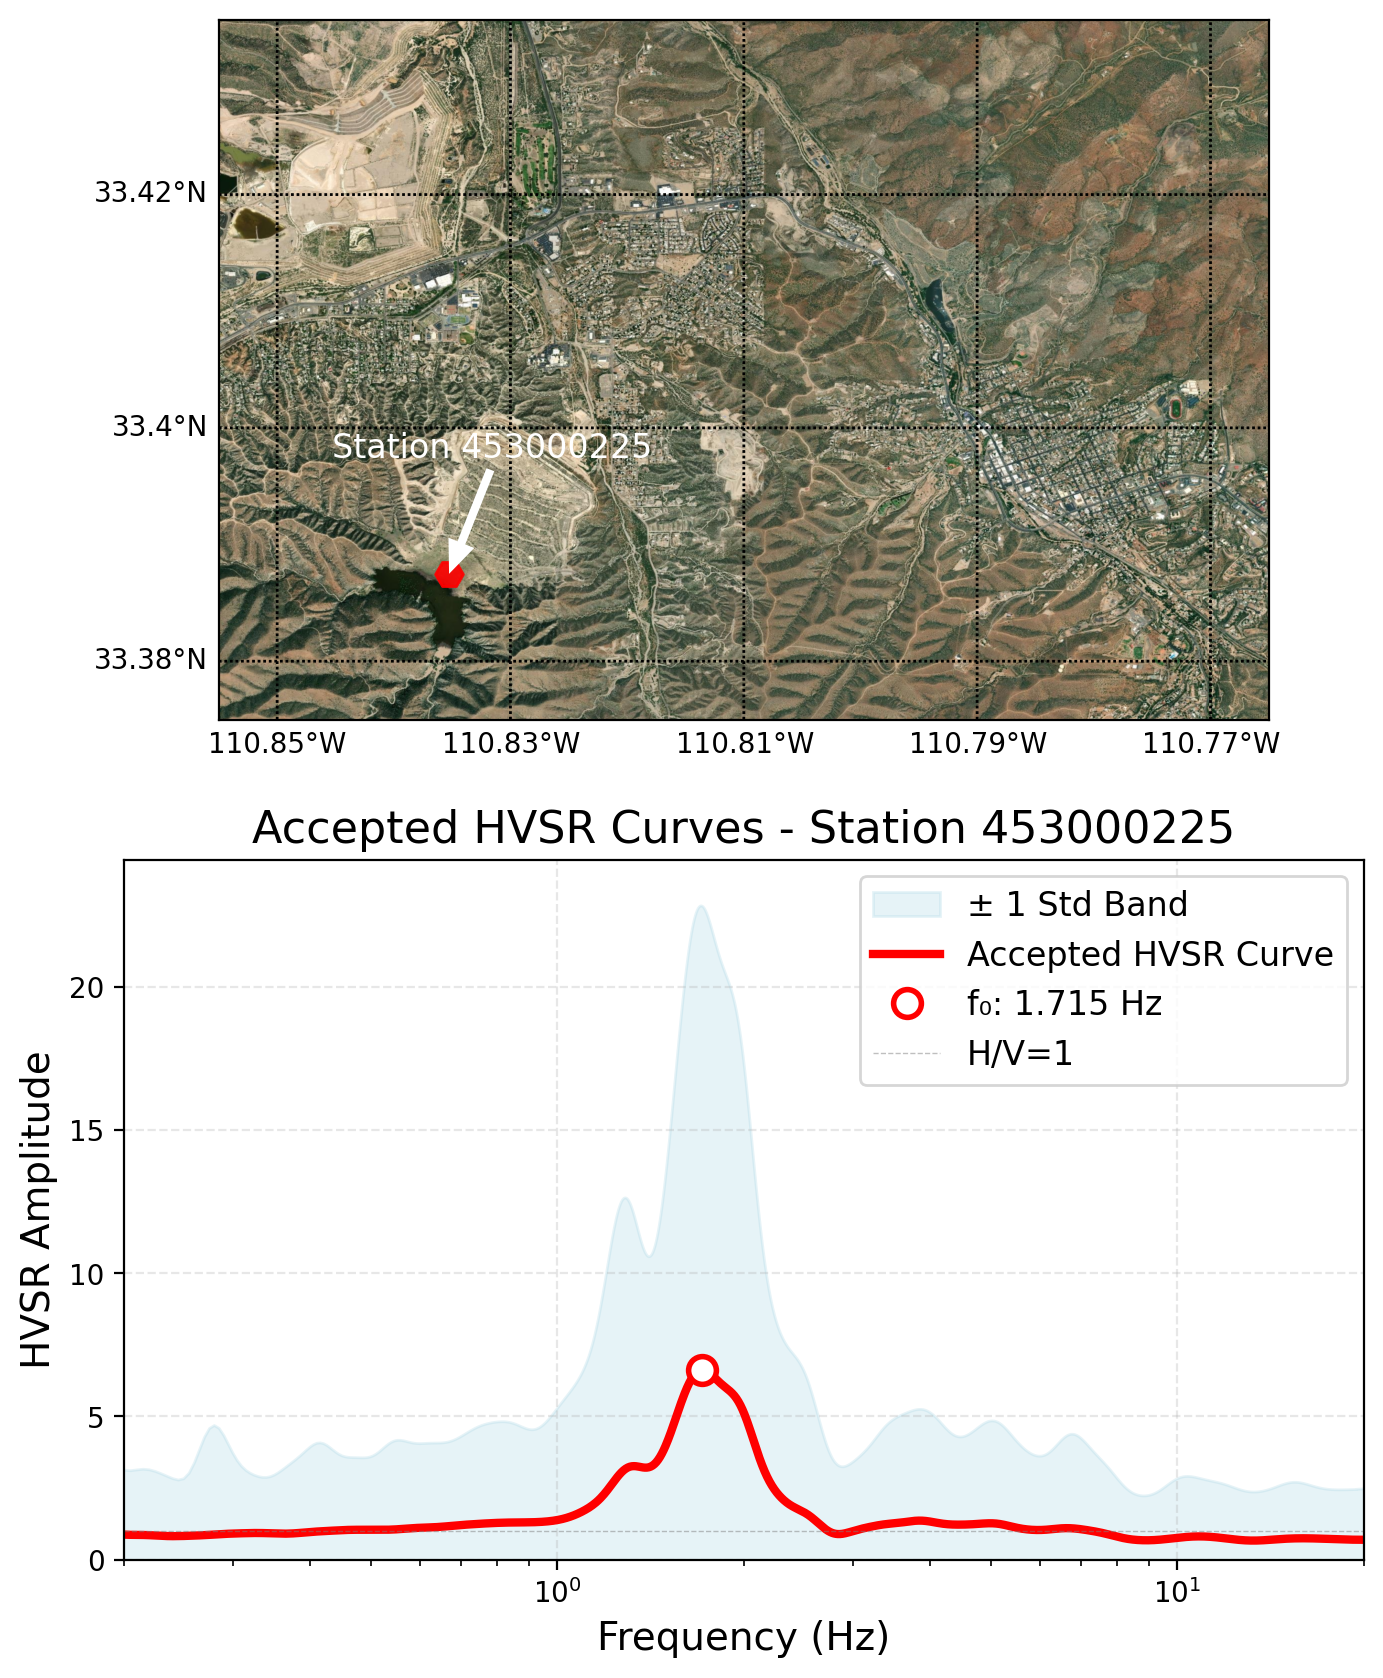

In [8]:
# Visualization
def plot_hvsr_results_with_map(station_id, result, coordinates, output_dir):

    try:
        try:
            from mpl_toolkits.basemap import Basemap
            HAS_BASEMAP = True
        except ImportError:
            HAS_BASEMAP = False
            print("Basemap not available")
        
        if HAS_BASEMAP and coordinates and coordinates[0] is not None:
            
            fig, (ax_map, ax_hvsr) = plt.subplots(2, 1, figsize=(8, 10), dpi=200, 
                                                   gridspec_kw={'height_ratios': [1, 1]})
            
            latitude, longitude, elevation = coordinates
            
            # Top panel: Basemap 
            m = Basemap(resolution='i', projection='cyl',
                        llcrnrlat=33.375, urcrnrlat=33.435,
                        llcrnrlon=-110.855, urcrnrlon=-110.765, ax=ax_map)
            m.arcgisimage(service='World_Imagery', xpixels=2000, dpi=200, verbose=False)
            m.drawstates()
            m.drawparallels(np.arange(33.38, 33.44, 0.02), labels=[1,0,0,1])
            m.drawmeridians(np.arange(-110.85, -110.76, 0.02), labels=[1,0,0,1])
            
            # Plot station
            m.scatter(longitude, latitude, 100, marker='H', color='red', alpha=0.9)
        
            ax_map.annotate(
                f'Station {station_id}',
                xy=(longitude, latitude),
                xytext=(longitude - 0.01, latitude + 0.01),
                arrowprops=dict(facecolor='white', edgecolor='none', width=3, headwidth=10),
                fontsize=12, color='white'
            )
            
        else:
            fig, ax_hvsr = plt.subplots(1, 1, figsize=(8, 10), dpi=200)
        
        # Bottom panel: HVSR curve with standard deviation band
        if result.hvsr_std is not None:
            ax_hvsr.fill_between(
                result.frequencies,
                result.hvsr_values - result.hvsr_std,
                result.hvsr_values + result.hvsr_std,
                alpha=0.3, color='lightblue', label='± 1 Std Band'
            )
        
        ax_hvsr.semilogx(result.frequencies, result.hvsr_values, 'r-', linewidth=3, 
                       label='Accepted HVSR Curve')
        
        peak_idx = result.hvsr_values.argmax()
        peak_freq = result.frequencies[peak_idx]
        peak_amp = result.hvsr_values[peak_idx]
        ax_hvsr.plot(peak_freq, peak_amp, 'ro', markersize=10, markerfacecolor='white', 
                     markeredgewidth=2, label=f'f₀: {peak_freq:.3f} Hz')
        
        ax_hvsr.axhline(1.0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5, label='H/V=1')
        
        ax_hvsr.set_ylabel("HVSR Amplitude", fontsize=14)
        ax_hvsr.set_xlabel("Frequency (Hz)", fontsize=14)
        ax_hvsr.set_title(f"Accepted HVSR Curves - Station {station_id}", fontsize=16)
        ax_hvsr.legend(fontsize=12, loc='upper right')
        ax_hvsr.grid(True, alpha=0.3)
        
        
        ax_hvsr.set_xlim(0.2, 20)
        ax_hvsr.set_ylim(bottom=0)
        ax_hvsr.grid(True, linestyle='--', alpha=0.3)
        
        output_file = os.path.join(output_dir, f"{station_id}.png")
        plt.savefig(output_file, dpi=200, bbox_inches='tight')
        # plt.close(fig)
        
        print(f"Saved plot for station {station_id}: {output_file}")
        
    except Exception as e:
        print(f"Error creating plot for station {station_id}: {e}")

# Create plots for all processed stations
if all_results:
    print("Creating Visualization Plots")
    for station_id, result in all_results.items():
        # Get coordinates if available
        coordinates = get_station_coordinates(station_metadata, station_id)
        
        # Create plot
        plot_hvsr_results_with_map(station_id, result, coordinates, OUTPUT_DIR)
    
    print(f"Created plots for {len(all_results)} stations in {OUTPUT_DIR}")
else:
    print("No results available for plotting")
